## Time to get your hands dirty! Supernova distances and redshifts (part 2 - 3)

### Part 2 (start in class)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. To start with, feel free to tweak the hyperparameters manually. But, of course, a publication-quality result will require a cross-validation analysis.

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using your GPR fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

### Part 3 (for the exam)

*(I know this assignment is longer and more convoluted, but we're getting towards the end of the class and it's important to draw connections between the different things we've done)*

We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). The answer is:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$

- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data, however you want to do it, using tecniques we've seen throughout the course. Some ideas:
    - Set up a Bayesian framework and use MCMC. 
    - Set up a fully-connected neural network (see end of the class).

- What are the measured value of $H_0$ and $\Omega_m$. What's they errors? Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

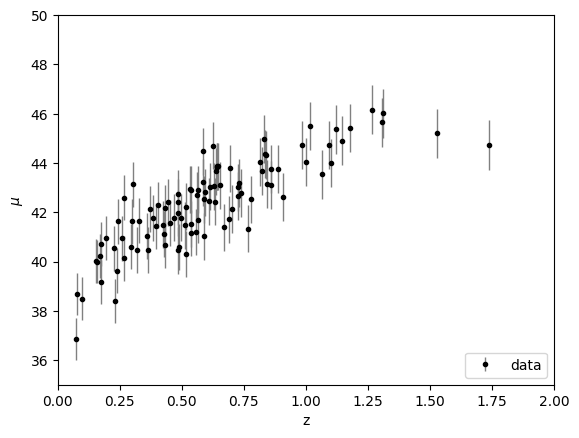

In [1]:

import numpy as np
import pylab as plt
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_479080/2659520284.py:28: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(z_fit.ravel(), mu_pred - sigma, mu_pred + sigma, color='blue', alpha=0.2, label='1-$\sigma$')
/tmp/ipykernel_479080/2659520284.py:29: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(z_fit.ravel(), mu_pred - 2*sigma, mu_pred + 2*sigma, color='blue', alpha=0.1, label='2-$\sigma$')
/home/bossi_ricky/WSL_Shared/myenv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


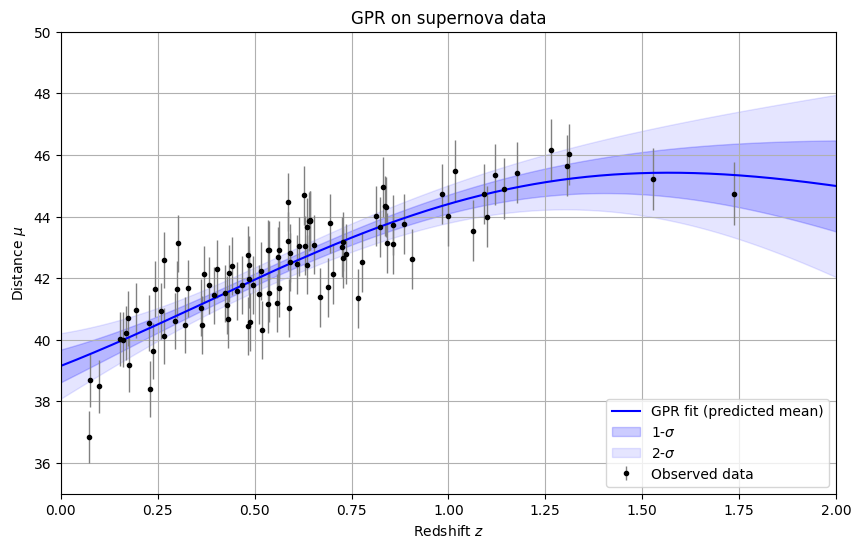

Optimized kernel (original data): 2.21**2 * RBF(length_scale=1.11) + WhiteKernel(noise_level=1e-05)


In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

X = z_sample.reshape(-1, 1)  # sklearn expects 2D array
y = mu_sample
dy = dmu

# The kernel is: constant * RBF + white noise (to handle measurement uncertainties)
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 10)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 10))
# The constant kernel starts at 1 and ranges from 10^-3 to 10^3; it represents the amplitude of the mu curve (i.e. how high it can go)
# RBF controls the smoothness and variation of the curve in z; bounds are chosen based on the z-range (this defines the shape of the curve)
# WhiteKernel = white noise to model observational noise

gp = GaussianProcessRegressor(kernel=kernel, alpha=dy**2, normalize_y=True)
# normalize_y sets the target to zero mean and unit variance before fitting

gp.fit(X, y)  # fit the model to the data

z_fit = np.linspace(0, 2, 1000).reshape(-1, 1)  # grid of z values for plotting

# Prediction with GPR
mu_pred, sigma = gp.predict(z_fit, return_std=True)
# sigma is the standard deviation of the predictive distribution (confidence band)

plt.figure(figsize=(10, 6))
plt.errorbar(z_sample, mu_sample, yerr=dy, fmt='.k', ecolor='gray', lw=1, label='Observed data')
plt.plot(z_fit, mu_pred, color='blue', label='GPR fit (predicted mean)')
plt.fill_between(z_fit.ravel(), mu_pred - sigma, mu_pred + sigma, color='blue', alpha=0.2, label='1-$\sigma$')
plt.fill_between(z_fit.ravel(), mu_pred - 2*sigma, mu_pred + 2*sigma, color='blue', alpha=0.1, label='2-$\sigma$')

plt.xlabel(r"Redshift $z$")
plt.ylabel(r"Distance $\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title("GPR on supernova data")
plt.grid(True)
plt.show()

# Interpret the results
print("Optimized kernel (original data):", gp.kernel_)

# scikit-learn’s GaussianProcessRegressor automatically optimizes the kernel hyperparameters by maximizing the log-marginal likelihood during fit().
#But: this optimization is local and depends on the initial kernel parameters and bounds you provide. It can get stuck in local minima or suboptimal solutions.


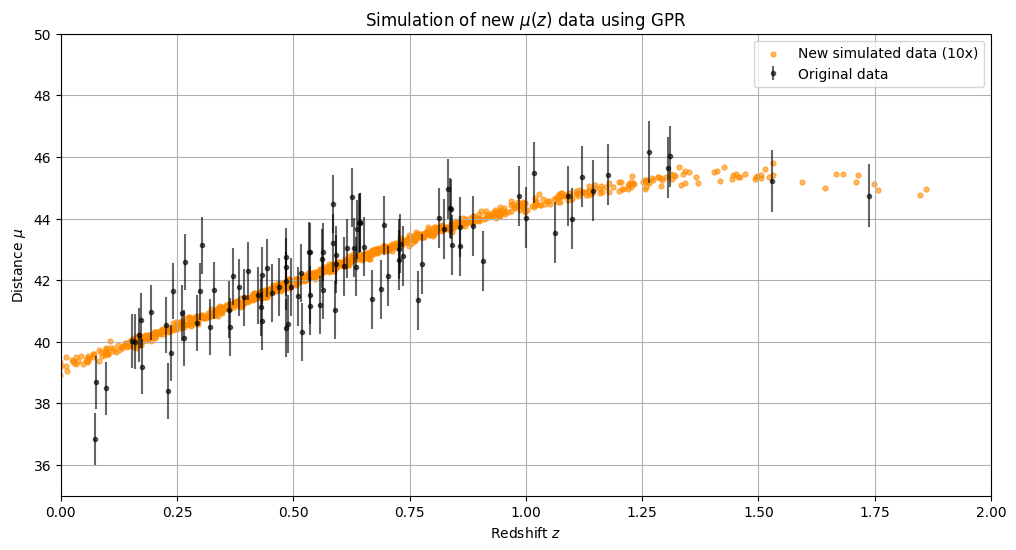

In [14]:
from scipy.stats import gaussian_kde

# Estimate PDF of z and generate 10x new z values
kde = gaussian_kde(z_sample) #that's the density function

z_new = kde.resample(1000).ravel()  # draw 1000 new z samples from his pdf

# Prediction on new z points
mu_new_pred, sigma_new_pred = gp.predict(z_new.reshape(-1, 1), return_std=True)
# use the GPR to evaluate new z values and get corresponding mu values on the function

# add realistic noise to mu
mu_simulated = np.random.normal(mu_new_pred, sigma_new_pred)

# Fit GPR on a regular grid for plotting
z_plot = np.linspace(0, 2, 10000).reshape(-1, 1)
mu_plot, sigma_plot = gp.predict(z_plot, return_std=True)


plt.figure(figsize=(12, 6))

# Original data
plt.errorbar(z_sample, mu_sample, yerr=dy, fmt='.k',  alpha=0.6, label='Original data')

# Simulated data
plt.scatter(z_new, mu_simulated, color='darkorange', s=50, alpha=0.6, label='New simulated data (10x)', marker='.')

plt.xlabel("Redshift $z$")
plt.ylabel(r"Distance $\mu$")
plt.legend()
plt.title(r"Simulation of new $\mu(z)$ data using GPR")
plt.grid(True)
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()


/tmp/ipykernel_479080/2915206685.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(z_new, mu_simulated, yerr = np.mean(dmu),fmt='.k', color='orange', alpha=0.3, label='Simulated data (10x)')


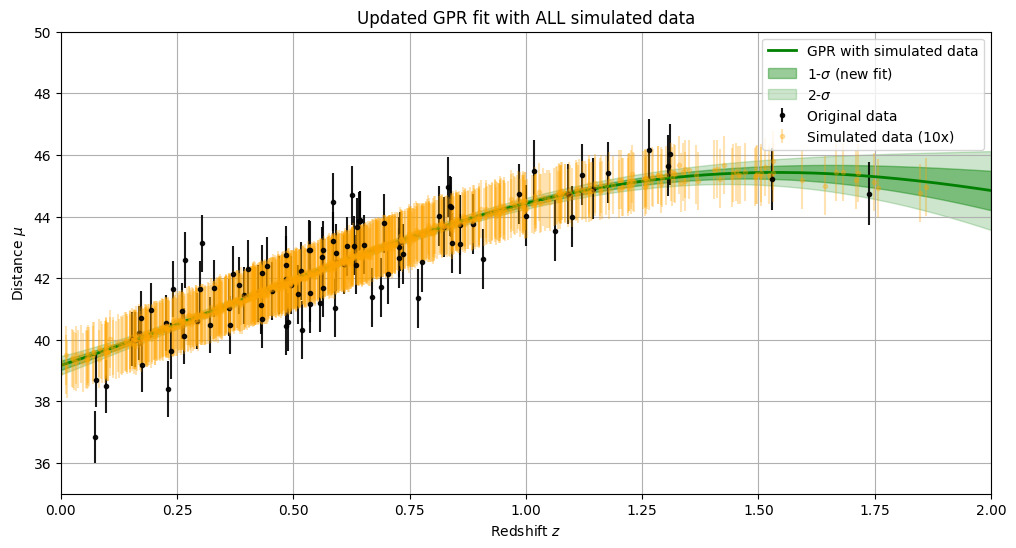

Optimized kernel (original data): 2.29**2 * RBF(length_scale=1.24) + WhiteKernel(noise_level=1e-05)
Optimized kernel (total data): 2.23**2 * RBF(length_scale=1.21) + WhiteKernel(noise_level=1.06e-05)


In [15]:
X_total = np.concatenate([z_sample, z_new]).reshape(-1, 1)  # concatenate all z values
y_total = np.concatenate([mu_sample, mu_simulated])         # concatenate all mu values

dy_simulated = np.full(mu_simulated.shape, np.mean(dmu))    # assign homoscedastic noise to simulated data equal to the mean of original errors
dy_total = np.concatenate([dmu, dy_simulated])              # concatenate all error bars

# Refit GPR on all data
gp_total = GaussianProcessRegressor(kernel=kernel, alpha=dy_total**2, normalize_y=True)
gp_total.fit(X_total, y_total)

# Prediction
z_fit = np.linspace(0, 2, 1000).reshape(-1, 1)
mu_fit, sigma_fit = gp_total.predict(z_fit, return_std=True)

plt.figure(figsize=(12, 6))
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt='.k', label='Original data', alpha=0.9)
plt.errorbar(z_new, mu_simulated, yerr = np.mean(dmu),fmt='.k', color='orange', alpha=0.3, label='Simulated data (10x)')
plt.plot(z_fit, mu_fit, color='green', lw=2, label='GPR with simulated data')
plt.fill_between(z_fit.ravel(), mu_fit - sigma_fit, mu_fit + sigma_fit,
                 color='green', alpha=0.4, label=r'1-$\sigma$ (new fit)')
plt.fill_between(z_fit.ravel(), mu_fit - 2*sigma_fit, mu_fit + 2*sigma_fit, color='green', alpha=0.2, label=r'2-$\sigma$')


plt.xlabel("Redshift $z$")
plt.ylabel(r"Distance $\mu$")
plt.title("Updated GPR fit with ALL simulated data")
plt.legend()
plt.grid(True)
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

# Interpret the results
print("Optimized kernel (original data):", gp.kernel_)
print("Optimized kernel (total data):", gp_total.kernel_)


  0%|          | 0/20 [00:00<?, ?it/s]

/home/bossi_ricky/WSL_Shared/myenv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/bossi_ricky/WSL_Shared/myenv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/bossi_ricky/WSL_Shared/myenv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/bossi_ricky/WSL_Shared

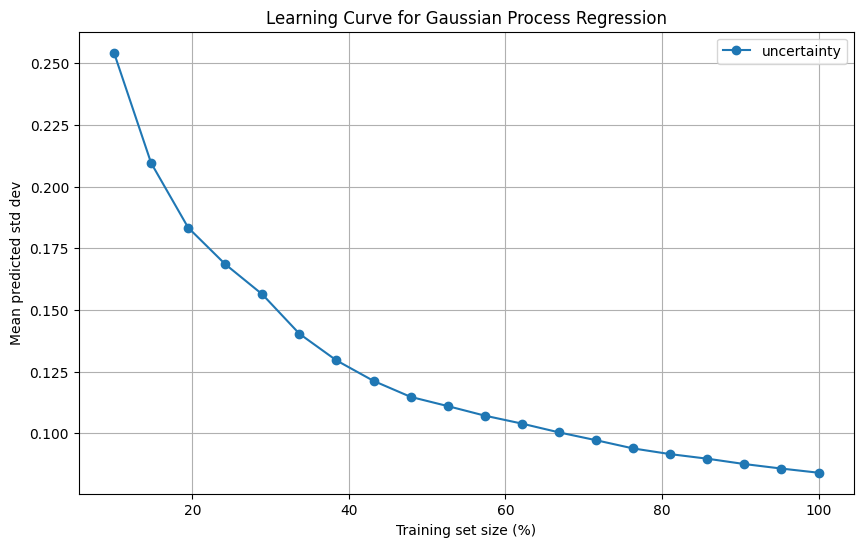

In [ ]:
from tqdm.notebook import tqdm
train_sizes = np.linspace(0, 1.0, 20)  # percentuali di dati usati
train_precisions = []

for frac in tqdm(train_sizes):
    n_train = int(frac * len(X_total))
    X_train = X_total[:n_train]
    y_train = y_total[:n_train]
    dy_train = dy_total[:n_train]

    gp = GaussianProcessRegressor(kernel=kernel, alpha=dy_train**2, normalize_y=True)
    gp.fit(X_train, y_train)

    _, sigma_train = gp.predict(X_train, return_std=True)
    train_precisions.append(np.mean(sigma_train))

# Plot precision learning curve (la sigma è in unità di y, quindi "errore")
plt.figure(figsize=(10,6))
plt.plot(train_sizes * 100, train_precisions, 'o-', label='uncertainty')

plt.xlabel('Training set size (%)')
plt.ylabel('Mean predicted std dev')
plt.title('Learning Curve for Gaussian Process Regression')
plt.legend()
plt.grid(True)
plt.show()


# Non linear fitting

In [ ]:
from astropy.cosmology import LambdaCDM

def model(redshift, Hubble_const, omega_matter=1):
    cosmology = LambdaCDM(H0=Hubble_const, Om0=omega_matter, Ode0=1 - omega_matter) # The cosmological model
    dist_modulus = cosmology.distmod(redshift) # Calculate the distance modulus at the specified redshift
    return dist_modulus.value

#Compute loglikelihood
def loglikelihood(parameters):
    hubble, omega_m = parameters
    if omega_m < 0:
        return -np.inf
    
    # Compute the predicted distance modulus using the model
    mu_model = model(z_sample, hubble, omega_m)
    return -0.5 * np.sum(((mu_sample - mu_model) / dmu)**2 + np.log(2 * np.pi * dmu**2))

def prior_transform(u):
    # u: array with 2 values sampled uniformly from [0,1]
    # Transform first parameter from [0,1] to Omega_m in [0.1, 1]
    omega_m = 0.1 + 0.9 * u[0]
    
    # Transform second parameter from [0,1] to H0 in [30, 100]
    H0 = 30 + 70 * u[1]
    return np.array([H0, omega_m])

In [43]:
import dynesty

sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim=2, nlive=1000)
# Run nested sampling
sampler.run_nested()
sresults = sampler.results

2771it [00:50, 54.76it/s, +1000 | bound: 0 | nc: 1 | ncall: 17042 | eff(%): 23.507 | loglstar:   -inf < -132.813 <    inf | logz: -135.293 +/-  0.019 | dlogz:  0.001 >  1.009]


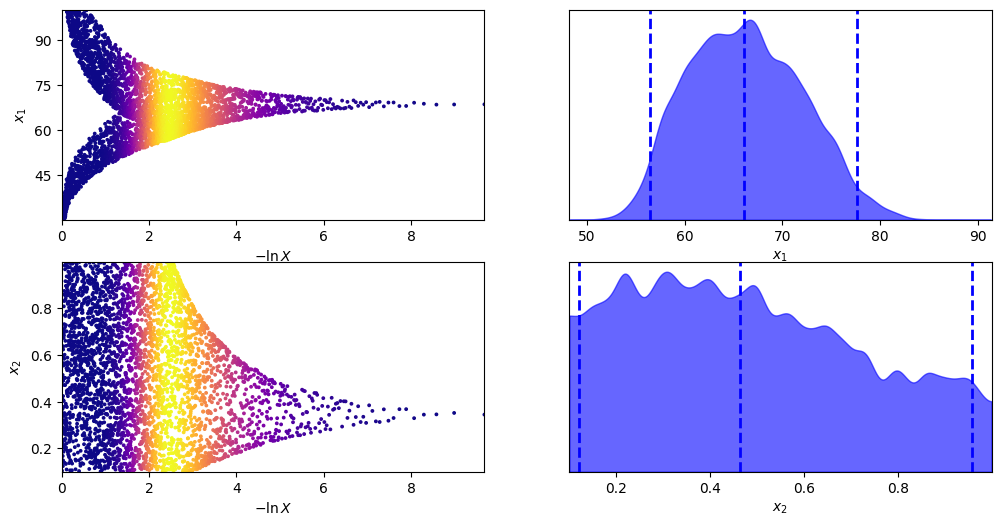

In [ ]:
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

tfig, taxes = dyplot.traceplot(sresults) # Shows trace plots of parameter samples over iterations

In [45]:
# Compute weighted mean and standard deviation of parameters from nested sampling results
samples = sresults.samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples, weights)
std_dev = np.sqrt(np.diag(cov))

print(f"Omega_m = {mean[0]:.3f} ± {std_dev[0]:.3f}")
print(f"H0 = {mean[1]:.2f} ± {std_dev[1]:.2f}")

Omega_m = 66.247 ± 5.738
H0 = 0.49 ± 0.24


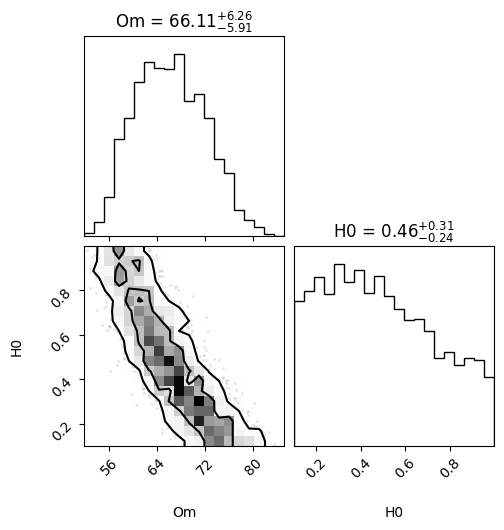

In [47]:
import corner
samples_equal = dyfunc.resample_equal(samples, weights) #dynesty returns weighted samples — this converts them to equally-weighted ones
fig = corner.corner(samples_equal, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71])

In [48]:
def model_no_dark_energy(redshift, Hubble_const):
    cosmology = LambdaCDM(H0=Hubble_const, Om0=1, Ode0=0)
    dist_modulus = cosmology.distmod(redshift)
    return dist_modulus.value

def loglikelihood_no_dark_energy(params):
    H0, = params
    mu_model = model_no_dark_energy(z_sample, H0)
    return -0.5 * np.sum(((mu_sample - mu_model) / dmu)**2 + np.log(2 * np.pi * dmu**2))

def prior_transform_no_dark_energy(u):
    # Uniform prior on H0 between 30 and 100 km/s/Mpc
    H0 = 30 + 70 * u[0]
    return np.array([H0])

In [49]:
# Run nested sampling
sampler_noDE = dynesty.NestedSampler(loglikelihood_no_dark_energy, prior_transform_no_dark_energy, ndim=1, nlive=1000)
sampler_noDE.run_nested()
results_noDE = sampler_noDE.results

2828it [00:49, 56.90it/s, +1000 | bound: 0 | nc: 1 | ncall: 17421 | eff(%): 23.312 | loglstar:   -inf < -133.530 <    inf | logz: -135.977 +/-    nan | dlogz:  0.001 >  1.009]


In [50]:
# Compute mean and standard deviation for H0
samples_noDE = results_noDE.samples # samples
weights_noDE = np.exp(results_noDE.logwt - results_noDE.logz[-1])  # normalized weights
mean_noDE, cov_noDE = dyfunc.mean_and_cov(samples_noDE, weights_noDE)
std_noDE = np.sqrt(np.diag(cov_noDE))

print(f"H0 (no dark energy) = {mean_noDE[0]:.2f} ± {std_noDE[0]:.2f}")

H0 (no dark energy) = 57.78 ± 2.55


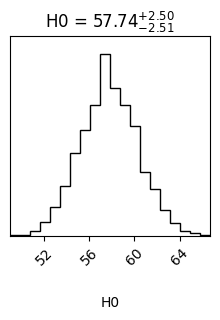

In [51]:
samples_equal_noDE = dyfunc.resample_equal(samples_noDE, weights_noDE)  # Resample weighted samples.
fig = corner.corner(samples_equal_noDE, labels=["H0"], levels=[0.68,0.95], show_titles=True, truth=[71])

In [52]:
# Compute Bayes factor (evidence ratio between models)
Z_with_DE = np.exp(sampler.results.logz[-1])
Z_no_DE   = np.exp(sampler_noDE.results.logz[-1])

bayes_factor = Z_with_DE / Z_no_DE
print(f"Bayes factor (with DE / no DE) = {bayes_factor:.2f}")

Bayes factor (with DE / no DE) = 1.98
